In [1]:
# define and fit a discriminator model
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from tqdm import tqdm

In [2]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.title('Epoch : #{}'.format(epoch))
    pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in tqdm(range(n_epochs)):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+0) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
    
    summarize_performance(i, g_model, d_model, latent_dim)

In [12]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.5099999904632568 0.4300000071525574


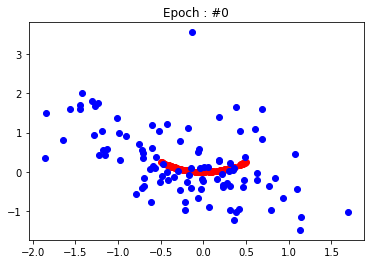

 20%|██        | 2000/10000 [01:48<07:19, 18.20it/s]

2000 0.4000000059604645 0.6800000071525574


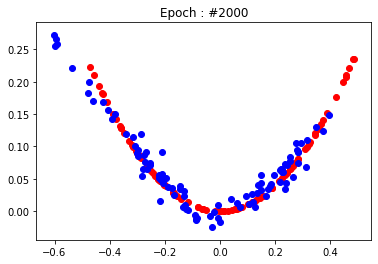

 40%|████      | 4000/10000 [03:37<05:12, 19.18it/s]

4000 0.4699999988079071 1.0


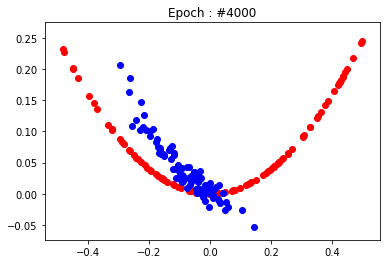

 60%|█████▉    | 5999/10000 [05:25<03:35, 18.53it/s]

6000 0.3700000047683716 0.75


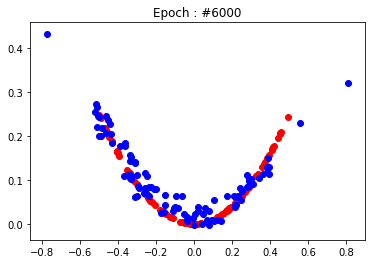

 80%|████████  | 8000/10000 [07:14<01:52, 17.75it/s]

8000 0.6399999856948853 0.5600000023841858


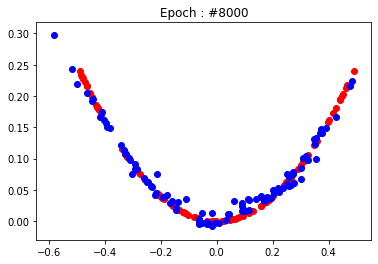

100%|██████████| 10000/10000 [09:04<00:00, 18.37it/s]


9999 0.44999998807907104 0.6700000166893005


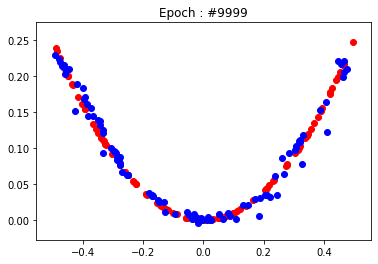

In [3]:
# size of the latent space
latent_dim = 5
n_epochs = 10000

# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, n_epochs)

Text(0.5, 1.0, 'n_epochs : 10000')

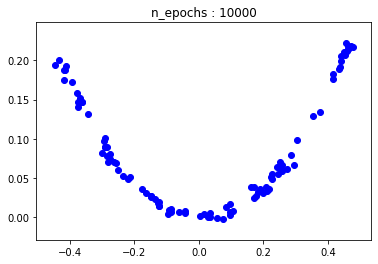

In [14]:
n_batch = 100
x_gan = generate_latent_points(latent_dim, n_batch)
x_fake = generator.predict(x_gan)

pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
pyplot.title('n_epochs : {}'.format(n_epochs))

In [15]:
x_gan

array([[ 1.26465380e+00,  2.31753961e-01,  3.56219441e-01,
         6.14942107e-01, -1.49893663e+00],
       [-2.65566756e-01,  1.56900716e-01,  1.24084386e+00,
        -8.73776597e-01, -6.03672691e-02],
       [-1.25247101e-01, -1.25727242e+00, -2.44677734e-01,
        -1.57937920e+00, -2.10303826e+00],
       [ 2.50857181e+00,  3.86901283e-02, -2.12068987e+00,
        -2.76884210e-01,  9.01475430e-01],
       [-1.86265702e+00, -7.83879014e-01, -6.91870595e-01,
         3.92702768e-01, -1.78941733e+00],
       [-9.52229100e-02,  1.47072894e-01, -3.04699471e+00,
        -1.42943808e+00, -1.34447925e-01],
       [ 1.39258864e-01,  6.89428804e-01, -1.26816779e+00,
        -1.91718071e-01,  7.86765797e-01],
       [-5.03584091e-01, -1.95312449e-01, -1.18945390e+00,
         4.57812012e-01,  1.23801074e+00],
       [ 9.71507268e-02, -1.92684844e-01, -1.08739074e-02,
        -4.67280334e-01, -1.01700377e+00],
       [ 1.70023414e-01, -3.07608881e-01, -1.42008358e+00,
         1.62827240e-01

### References
* How to Develop a 1D Generative Adversarial Network From Scratch in Keras <br/>
https://archive.is/zSpu1<br/> 
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/